# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os

import torch
from torch import nn
from torch.utils import data

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.

In [2]:
def generate_gaussian_bb_labels(bbs: list[list[str]], quant: int = 4) -> list:
    """Generate sample energy labels for the bbs as the sum of  a gaussian energy
    distribution per instruction

    Args:
        bbs (list[list[str]]): bbs
        quant (int, optional): different scale per instruction energy. Defaults to 4.

    Returns:
        list: sample energies for bbs
    """

    mu, sigma = 1, 1

    data_insts = np.unique([inst.split()[0] for bb in bbs for inst in bb])
    gauss_means = {inst: start*quant + mu for start, inst in enumerate(data_insts)}
    bb_energies = [round(sum([random.gauss(gauss_means[inst.split()[0]], sigma) for inst in bb]), 2) for bb in bbs]

    return bb_energies

In [3]:
data_files = os.listdir("../../dataset/sample_bb_data")

if "TEST_BB_Dataset.pkl" not in data_files:
    data = []
    basic_block = []

    #Reading basic block data
    with open("../../dataset/sample_bb_data/sample_basic_blocks.txt") as fIn:
        for line in tqdm.tqdm(fIn, desc='Read file'):
            #line start with "@" symbols the begging of a new basic block
            if line[0] == "@":
                data.append(basic_block)
                basic_block = []
            else:
                basic_block.append(line.rstrip())

    
    #Removing possible empty bbs
    data = [bb for bb in data if len(bb) > 0]
    labels = generate_gaussian_bb_labels(data)
    data_df = pd.DataFrame({"basic_blocks": data, "energy_labels": labels})
    data_df.to_pickle("../../dataset/sample_bb_data/TEST_BB_Dataset.pkl")
else:
    data_df = pd.read_pickle("../../dataset/sample_bb_data/TEST_BB_Dataset.pkl")

if "bb_embeddings" not in data_df.columns:
    data_df["bb_embeddings"] = data_df.basic_blocks.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/sample_bb_data/TEST_BB_Dataset.pkl")

Unique basic blocks

In [4]:
bb_set = set(tuple(bb) for bb in data_df.basic_blocks)
print(f"Number of basic blocks: {data_df.shape[0]}")
print(f"Unique basic blocks: {len(bb_set)}")

Number of basic blocks: 11219
Unique basic blocks: 969


Since energy labels are not availiable yet we will consider a random float between 0 and 5 as an energy label for each basic block

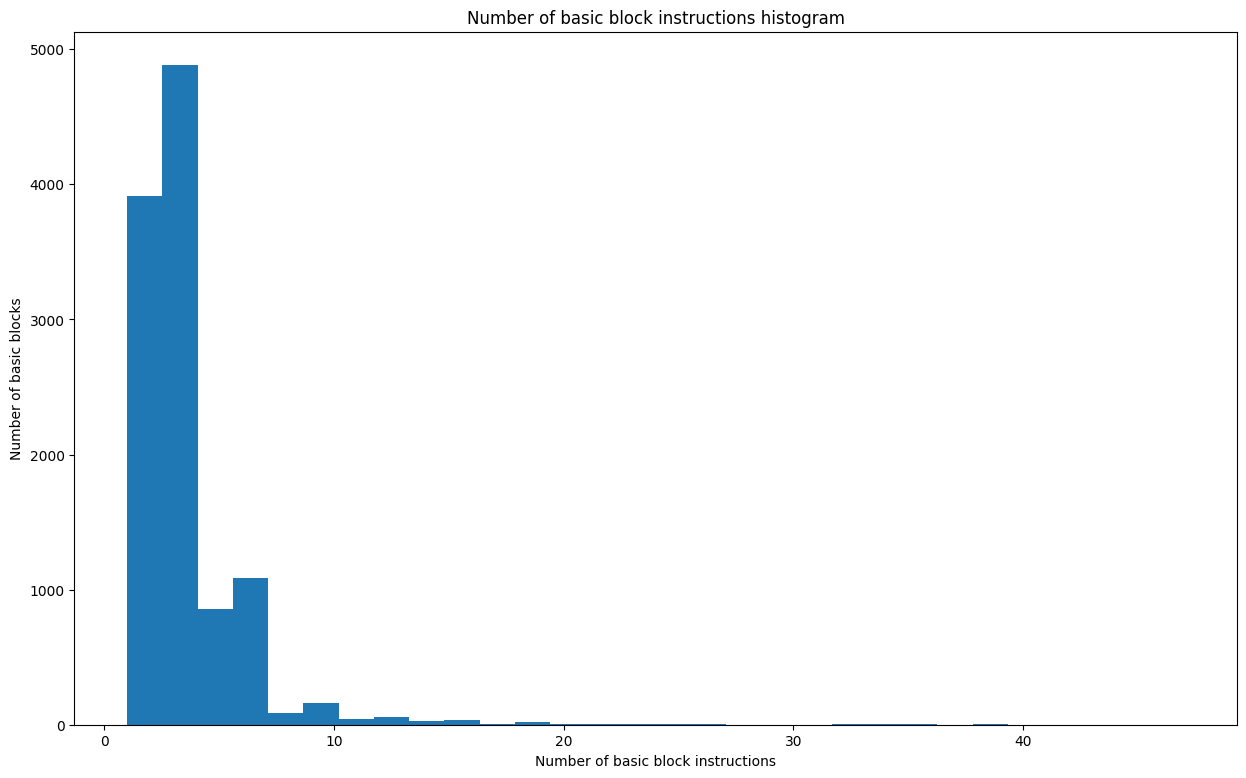

In [5]:
bb_instruction_num = data_df.basic_blocks.apply(lambda x: len(x)).values

plt.figure(figsize=(15,9))
plt.title("Number of basic block instructions histogram")
plt.xlabel("Number of basic block instructions")
plt.ylabel("Number of basic blocks")
plt.hist(bb_instruction_num, bins = 30)
plt.show()

In [6]:
MAX_INSTRUCTIONS = 8

data_df = data_df[data_df.basic_blocks.apply(lambda x: len(x)) <= MAX_INSTRUCTIONS]
data_df = data_df.reset_index(drop=True)
#data_df = data[:10]

Let's also inspect the labels' distribution

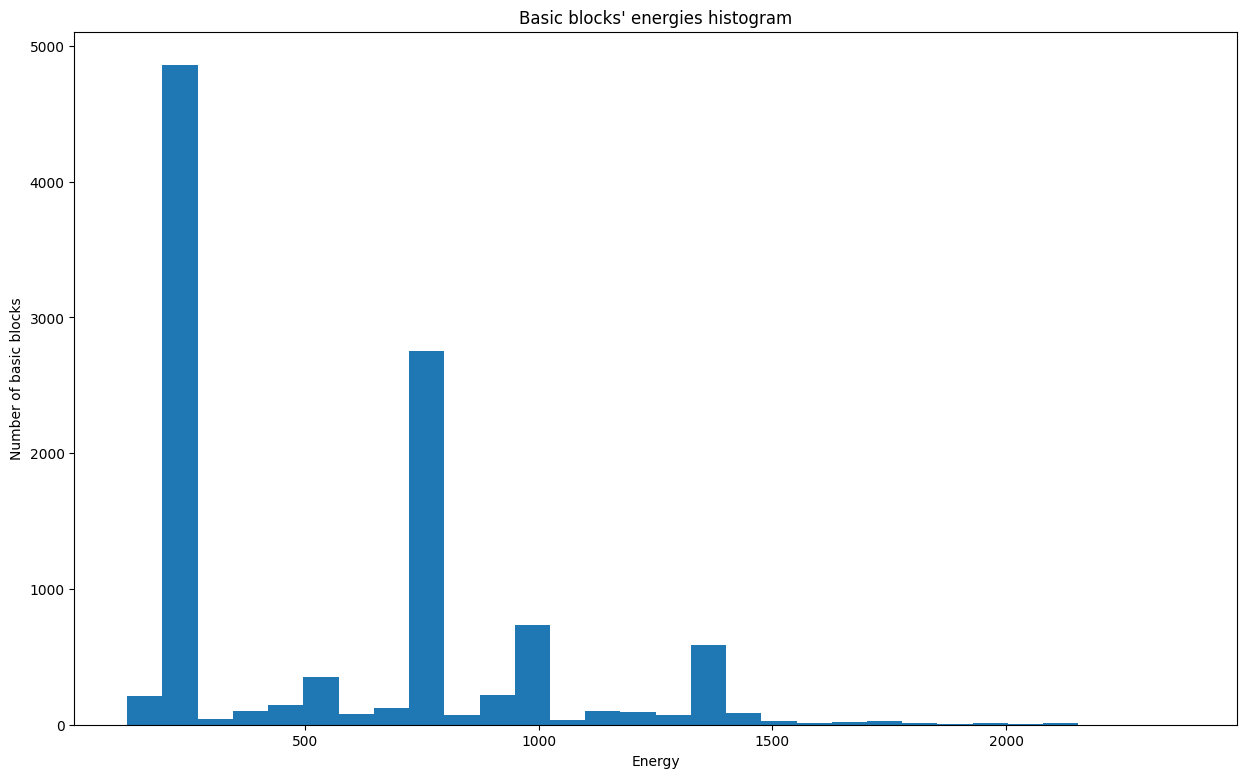

In [7]:
energies = data_df.energy_labels.values

plt.figure(figsize=(15,9))
plt.title("Basic blocks' energies histogram")
plt.xlabel("Energy")
plt.ylabel("Number of basic blocks")
plt.hist(energies, bins = 30)
plt.show()

Pytorch custom dataset

In [8]:
split = 0.8

bb_df_train = data_df[:int(0.8 * len(data_df))]
bb_df_val = data_df[int(0.8 * len(data_df)):]

In [9]:
BATCH_SIZE = 32
mean = False

train_data = dataset.EnergyPredictionDataset(bb_df_train, mean=mean)
if mean:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=utils.collate_fn)

val_data = dataset.EnergyPredictionDataset(bb_df_val, mean=mean)
if mean:
    val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=utils.collate_fn)

# LSTM Model

In [10]:
class LSTM_Regressor(nn.Module):

    def __init__(self, emb_size: int, hidden_size: int = 16, num_layers: int = 2, bidirectional: bool = False) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.1,
        )

        self.dense = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(128, 16)
        self.regressor = nn.Linear(16, 1)

    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda())
        
        return hidden

In [11]:
EMBEDDING_DIM = train_data.__getitem__(0)[0][0].shape[0]
NUM_LAYERS = 10
HIDDEN_DIM = 256

model = LSTM_Regressor(emb_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, num_layers=NUM_LAYERS)
print(model)

LSTM_Regressor(
  (lstm): LSTM(128, 256, num_layers=10, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (smaller_dense): Linear(in_features=128, out_features=16, bias=True)
  (regressor): Linear(in_features=16, out_features=1, bias=True)
)


In [12]:
EPOCHS = 100

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=0.01)

model.cuda()
model.train()

cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    hidden_state = model.init_hidden(batch_size=BATCH_SIZE)
    losses = []
    for embeddings, _, labels in train_loader:

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        hidden_state = tuple([each.data for each in hidden_state])


        output, hidden_state = model(embeddings, hidden_state)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.item())

    val_h = model.init_hidden(BATCH_SIZE)
    val_loss = []
    model.eval()
    for embeddings, _, labels in val_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output, val_h = model(embeddings, val_h)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MAE Train Loss: {round(np.mean(losses), 2)}, MAE Val Loss: {round(np.mean(val_loss), 2)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/100, MAE Train Loss: 331.72, MAE Val Loss: 345.52
Epoch: 2/100, MAE Train Loss: 327.49, MAE Val Loss: 341.92
Epoch: 3/100, MAE Train Loss: 326.96, MAE Val Loss: 341.36
Epoch: 4/100, MAE Train Loss: 323.68, MAE Val Loss: 345.12
Epoch: 5/100, MAE Train Loss: 326.03, MAE Val Loss: 342.6
Epoch: 6/100, MAE Train Loss: 325.9, MAE Val Loss: 340.74
Epoch: 7/100, MAE Train Loss: 330.6, MAE Val Loss: 342.45
Epoch: 8/100, MAE Train Loss: 327.77, MAE Val Loss: 356.73
Epoch: 9/100, MAE Train Loss: 322.81, MAE Val Loss: 346.08
Epoch: 10/100, MAE Train Loss: 323.52, MAE Val Loss: 341.74
Epoch: 11/100, MAE Train Loss: 326.86, MAE Val Loss: 340.48
Epoch: 12/100, MAE Train Loss: 326.48, MAE Val Loss: 341.51
Epoch: 13/100, MAE Train Loss: 326.21, MAE Val Loss: 342.17
Epoch: 14/100, MAE Train Loss: 324.6, MAE Val Loss: 346.51
Epoch: 15/100, MAE Train Loss: 325.64, MAE Val Loss: 340.21
Epoch: 16/100, MAE Train Loss: 331.24, MAE Val Loss: 343.11
Epoch: 17/100, MAE Train Loss: 327.72, MAE Val Loss: 

KeyboardInterrupt: 

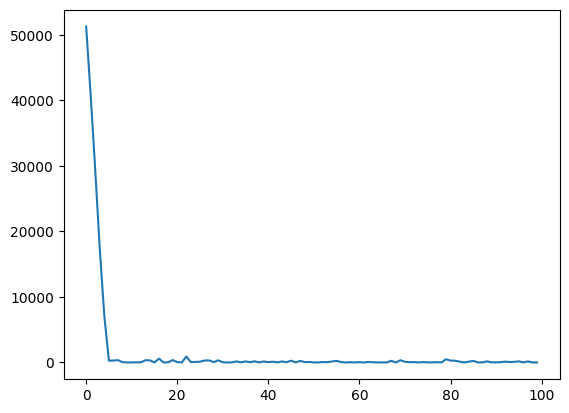

In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
plt.plot(val_losses)
plt.show()

# Simple Model

In [10]:
class Simple_Regressor(nn.Module):

    def __init__(self, emb_size: int) -> None:
        super().__init__()

        self.dense = nn.Linear(emb_size, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 16)
        self.dense5 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.05)
        self.regressor = nn.Linear(4, 1)

    def forward(self, x):
        
        out = self.dense(x)
        out = self.dropout(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)
        out = self.dropout(out)
        out = self.dense4(out)
        out = self.dropout2(out)
        out = self.dense5(out)
        out = self.regressor(out)

        return out

In [11]:
EMBEDDING_DIM = train_data.__getitem__(0)[0].shape[0]

model = Simple_Regressor(emb_size=EMBEDDING_DIM)
print(model)

Simple_Regressor(
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=16, bias=True)
  (dense5): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (regressor): Linear(in_features=4, out_features=1, bias=True)
)


In [12]:
EPOCHS = 100

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=0.01)

model.cuda()
model.train()

#cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    losses = []
    for embeddings, labels in train_loader:
        #cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        output = model(embeddings)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        losses.append(round(loss.item(), 2))

    #if cnt % 100 == 0:

    val_loss = []
    model.eval()
    for embeddings, labels in val_loader:

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output = model(embeddings)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MAE Train Loss: {round(np.mean(losses), 2)}, MAE Val Loss: {round(np.mean(val_loss), 2)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/100, MAE Train Loss: 192.95, MAE Val Loss: 357.32
Epoch: 2/100, MAE Train Loss: 131.87, MAE Val Loss: 377.38
Epoch: 3/100, MAE Train Loss: 141.22, MAE Val Loss: 423.4
Epoch: 4/100, MAE Train Loss: 125.6, MAE Val Loss: 317.88
Epoch: 5/100, MAE Train Loss: 127.73, MAE Val Loss: 353.52
Epoch: 6/100, MAE Train Loss: 129.13, MAE Val Loss: 382.5
Epoch: 7/100, MAE Train Loss: 121.53, MAE Val Loss: 298.53
Epoch: 8/100, MAE Train Loss: 133.41, MAE Val Loss: 244.04
Epoch: 9/100, MAE Train Loss: 127.47, MAE Val Loss: 376.82
Epoch: 10/100, MAE Train Loss: 131.75, MAE Val Loss: 328.23
Epoch: 11/100, MAE Train Loss: 121.3, MAE Val Loss: 311.68
Epoch: 12/100, MAE Train Loss: 109.81, MAE Val Loss: 277.68
Epoch: 13/100, MAE Train Loss: 136.21, MAE Val Loss: 352.99
Epoch: 14/100, MAE Train Loss: 129.19, MAE Val Loss: 402.51
Epoch: 15/100, MAE Train Loss: 127.24, MAE Val Loss: 314.98
Epoch: 16/100, MAE Train Loss: 122.27, MAE Val Loss: 296.66
Epoch: 17/100, MAE Train Loss: 118.51, MAE Val Loss: 

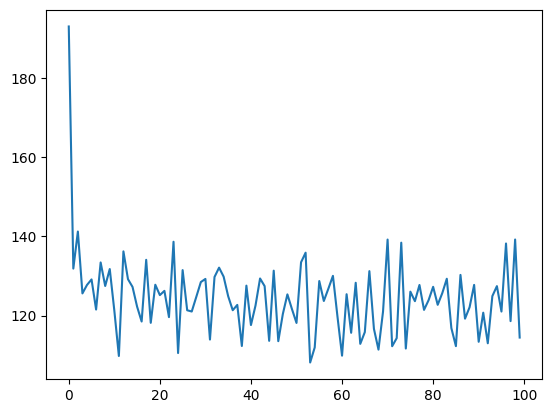

In [13]:
plt.plot(train_losses)
plt.show()

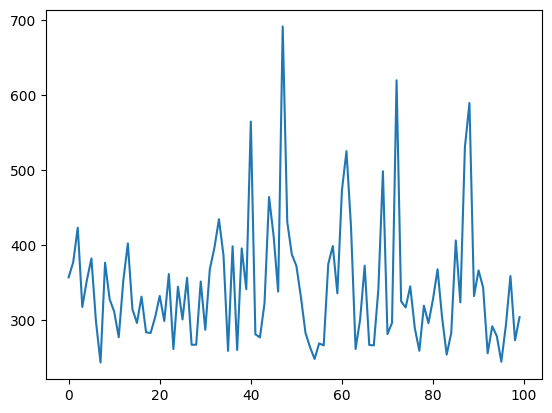

In [14]:
plt.plot(val_losses)
plt.show()

In [15]:
median = np.median(bb_df_train.energy_labels.values)
std = np.std(bb_df_train.energy_labels.values)

print(f"Train labels median: {median}, Train labels std: {std}")

Train labels median: 317.14, Train labels std: 373.78569506173216


In [16]:
median = np.median(bb_df_val.energy_labels.values)
std = np.std(bb_df_val.energy_labels.values)

print(f"Val labels median: {median}, Val labels std: {std}")

Val labels median: 590.63, Val labels std: 425.4743643805453
